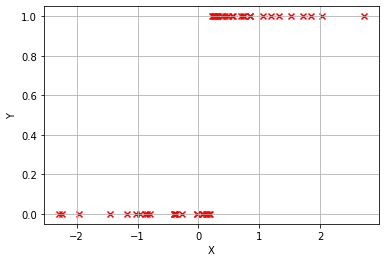

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_binary_data(m=50): 
    X = np.random.randn(m) #sample from a normal distribution
    X = np.array(sorted(X))
    Y = X > 0.2    # return binary vector with true where X above some threshold and false if below
    return X, Y #returns X (the input) and Y (labels)

def plot_data(X, Y):
    plt.figure()
    plt.scatter(X, Y, c='r', marker='x')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()
    
X, Y = make_binary_data()
plot_data(X, Y)

Previously, the output of our model could be any real number, negative or positive, unbounded in magnitude. Here the thing is a little more involved.

> In classification, we can interpret the model output as a confidence that the example belongs to a particular class.

Which bring us to...



## Logits



> vector (in binary case a scalar) of unnormalized probabilities in the range $(-\infty, \infty)$

Maybe you've noticed it is __exactly what we've been outputting with regression__!

You know what probability is, so logits are pretty similar, but:
- __50% chance (probability=$0.5$) is equal to logit=$0$ .__
- Anything below zero is less probable, anything above more

Logits are used for classification in order to:
- not making unnecessary operation transforming them into probabilities if we are after label (we will see the transformation shortly)
- for binary classification every output from our classifier which is greater than `1` is considered `True`, anything below is `False`

__Note:__ mathematically, the term logit refers to the log of the odds of a probability and __transforms probability (p below) back into $(-\infty, \infty)$ range__.
It can be written by the following formula:

$$
    L = \ln \frac{p}{1 - p}
$$

However, we will use the term logit later to simply refer to the values outputted by the model.



## From logits to probabilities



We can do this by applying a **sigmoid** function to our output:

<p align=center><img src=images/sigmoid.jpg width=1000></p>

> sigmoid squashes logits from $(-\infty, \infty)$ to $(0, 1)$ range which we can easily interpret

We can also write a function to compute the derivative of the sigmoid function.
We will need this to differentiate our loss with respect to the model parameters, as they only affect the loss through the sigmoid.

__Note:__ Sigmoid is the inverse function of logit

<p align=center><img src=images/sigmoid_deriv.jpg width=1000></p>

## The loss function for binary classification-  Binary cross entropy (BCE)

Basic formula for BCE is:

$$
    BCE = - (y\ln\hat{y} + (1-y)\ln(1-\hat{y}))
$$

We can break it down into parts exclusively:
- if the label is `1` $(1-y)\ln(1-\hat{y})$ is `0`
- if the label is `0` $y\ln\hat{y}$ is `0`

<p align=center><img src=images/bce.jpg width=1000></p>

### Why not calculate only one part per label?

Can't we calculate one part for `1` label and the second for `0` label with some kind of `if label == 0` switch? Yes, we could, but sometimes in machine learning & deep learning we use technique called `label smoothing`...

## Label smoothing

> Label smoothing changes `{0, 1}` labels into "soft targets", for example `{0.1, 0.9}`

### Why would we do that?

- It is impossible to reach `1` value for sigmoid in practice. Hence, even if our predicted probability is `0.99999` we will still have some loss left
- Same thing happens for `0` as it is really hard for the classifier to reach exactly this value

### How to do that?

- there are many implementations. Usually we subtract from largest labels (`1`) some constant and add it to `0` labels (for binary case)
- $\alpha$ is our __smoothing hyperparameter__, usually around `0.1`

### How does it help?

- Our classifier is __less confident__ about it's predictions. Due to inherit noise in data it is often desirable (especially for the more complex and powerful models, yes, neural networks are prime example)
- Predictions are more smooth and gradual. Instead of having rough jumps from `0.999` probability to `0.0001` probability in another case, our algorithms try to distribute the probability more evenly
- Classifier __does not try to "be sure" about hard examples so much__. As it has to reach `0.9` (let's say) instead of `1`, `0.8` will be also fine

## Binary Cross Entropy implementation

Let's start with naive implementation, simply follow the formula:

In [2]:
def bce(prediction, label):
    return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))

In [6]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

prediction = sigmoid(np.array([-0.5, 0.5, 0])) 
labels = np.array([0, 1, 1])

print(bce(prediction, labels))

[0.47407698 0.47407698 0.69314718]


But as usual, __numerical instability creeps in__. As a rule of thumb, always look suspicious at `exp` and it's inverse function `ln`:

In [7]:
prediction = np.array([1])
labels = np.array([0])

print(bce(prediction, labels))

[inf]


<ipython-input-2-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


In [8]:
prediction = np.array([0])
labels = np.array([1])

print(bce(prediction, labels))

[inf]


<ipython-input-2-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


In [9]:
prediction = np.array([0])
labels = np.array([0])

print(bce(prediction, labels))

[nan]


<ipython-input-2-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))
<ipython-input-2-f3031382e7cc>:2: RuntimeWarning: invalid value encountered in multiply
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


In [10]:
prediction = np.array([1])
labels = np.array([1])

print(bce(prediction, labels))

[nan]


<ipython-input-2-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))
<ipython-input-2-f3031382e7cc>:2: RuntimeWarning: invalid value encountered in multiply
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


### Analysis

- if our model __is very condfident and IS WRONG__ (first two cases) we are left with  `np.log(0)` (which goes towards $-\infty$, when we take `-` it is simply $\infty$ we observe). 
- if our model __is very condfident and IS RIGHT__ (last two cases) we will be left with $ 0 * \ln{0} $, hence with $ 0 * \infty $ which is undefined `NaN` (not a number)

Can we improve it somehow?

## Stable BCE

To stabilize binary cross entropy loss we can mix activation we saw earlier (`sigmoid`) and `binary cross entropy` itself.

### Formulation

One can derive numerically stable version. It takes some math so a few steps are skipped. You can see the formula that we will use [here](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits):

$$
\begin{align}
    BCE & = - (y\ln\hat{y} + (1-y)\ln(1-\hat{y})) \\
        & = - (y\ln(\frac{1}{1+e^{-x}}) + (1-y)\ln(1-\frac{1}{1+e^{-x}}) \\
        & ... \\
        & = x - xy + \ln(1 + e^{-x})
\end{align}
$$

Unfortunately this leaves us with $e^{-x}$ once again. After a few math tricks we come to this formula (really, go through it yourself to see some beautiful math tricks):

$$
    \max(0, x) - xy + \ln(1 + e^{-|x|})
$$

where `x` are logits, `y` are labels

You can see no matter the `x` value it will always be negative so `e` can only underflow which is fine for our case (and $\ln(1 + 0) = 0$). There are also [other formulas](https://discuss.pytorch.org/t/numerical-stability-of-bcewithlogitsloss/8246) but we won't go into details.

### Derivative

We also have to calculate derivative of `BCEWithLogits` to backpropagate through our model.

It is a little cumbersome, but remember you can always use [Wolfram Alpha](https://www.wolframalpha.com/) for such tasks (or it will get you some idea or direction at least).

Given that, the derivative is presented as:

$$
\begin{align}
    \frac{\partial BCE}{\partial x} &= \sigma(x) - y \\
    \frac{\partial BCE}{\partial y} &= -x
\end{align}
$$

__This binary cross entropy will work directly on `logits`__

## Finally let's build our binary classifier model class

We'll use the chain rule to compute the gradient with our previously defined loss function:

<p align=center><img src=images/binary_classification.jpg width=1000></p>

## Classification in sklearn

Sklearn has several different classification algorithms. We will use the `LogisticRegression` class from `sklearn.linear_model`, which is one of the most popular and simple ones. We will see more algorithms eventually, but the procedure for implementing them is very similar.

Also, to test it, we will use the breast cancer dataset from `sklearn.datasets`.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Now that we have already loaded and split our data, let's build and train our model. As with linear regression, we train the instance of the model on the training set and then predict the labels of the test set.

In [15]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9532163742690059


/home/ivanyingx/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Notice that the used solver did not converge. This is because we have a very simple dataset, so, as the sklearn documentation states, we can choose a different solver like this:

- For small datasets, `liblinear` is a good choice, whereas `sag` and `saga` are faster for large ones;
- For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss;
- `liblinear` is limited to one-versus-rest schemes.

So let's use `liblinear` solver.

In [19]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9649122807017544


Nice, not only the algorithm converged, but also we obtained a better accuracy.

## Summary

- The labels for classification problems should be an integer representing the index of the class which that example belongs to
- `logits` are unnormalized probability $(-\infty, \infty)$
- `sigmoid` transforms `logits` into probabilities
- Naive implementation of `sigmoid` is numerically unstable, more stable version exists
- Binary cross entropy is a new differentiable loss function that can be optimised to solve classification problems
- Binary classification can be implemented by having a single boolean integer label for each example, where 1 represents it being a member of that class and 0 represents it not being a member of that class